In [374]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import optuna
import wandb
from tqdm import tqdm
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from collections import deque

In [375]:
# Environment setup
env = gym.make('FrozenLake-v1', is_slippery=False)
n_actions = env.action_space.n
n_states = env.observation_space.n

In [376]:
# Neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(n_states, n_actions)

    def forward(self, x):
        return self.fc(x)
    
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.match_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        residual = self.match_channels(x)
        out = F.relu(self.bn(self.conv(x)))
        return out + residual

class ConvNet(nn.Module):
    def __init__(self, input_size, n_actions, conv_layers=[16,32], dropout_p=None):
        super(ConvNet, self).__init__()

        layers = []
        in_channels = 4  # Initial number of channels

        for out_channels in conv_layers:
            layers.append(ConvBlock(in_channels, out_channels))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)
        self.fc = nn.Linear(conv_layers[-1] * input_size, n_actions)
        self.dropout_p = dropout_p

        if dropout_p is not None:
            self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)

        x = x.view(x.size(0), -1)
        if self.dropout_p is not None:
            x = self.dropout(x)
        return self.fc(x)

In [377]:
# parameter count
model_to_count = ConvNet(n_states, n_actions)
sum(p.numel() for p in model_to_count.parameters() if p.requires_grad)

8004

In [378]:
def actions_from_q_values(q_values, epsilon):
    """
    Selects actions according to epsilon-greedy policy.
    """
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    else:
        # Apply softmax to convert q_values into probabilities
        probabilities = torch.nn.functional.softmax(q_values, dim=1)
        
        # Sample actions based on the probabilities
        actions = np.array([torch.multinomial(p, 1).item() for p in probabilities]).cpu().numpy()
        return actions


In [379]:
device = torch.device("mps")

In [380]:
def preprocess_state(position, map_layout):
    nrows, ncols = 4, 4  # Assuming a 4x4 map
    num_statuses = 4      # Four statuses including the agent's position

    # Initialize a 4x4x4 tensor for one-hot encoded state
    state_tensor = np.zeros((nrows, ncols, num_statuses))

    # Decode map layout
    layout_to_val = {b'F': 0, b'H': 1, b'S': 0, b'G': 3}  # Start 'S' also considered safe '0'

    for i in range(nrows):
        for j in range(ncols):
            # Set the appropriate index in the one-hot vector
            state_tensor[i, j, layout_to_val[map_layout[i][j]]] = 1

    # Convert position to 2D coordinates and update in state tensor
    row, col = divmod(position, ncols)
    # Resetting the cell to a blank state before marking the current position
    state_tensor[row, col] = np.array([0, 0, 0, 0])
    state_tensor[row, col, 2] = 1  # Marking the current position with one-hot encoding

    return torch.tensor(state_tensor, dtype=torch.float)


In [381]:
print(env.desc)

[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'H']
 [b'F' b'F' b'F' b'H']
 [b'H' b'F' b'F' b'G']]


In [382]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        
    def __len__(self):
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities, default=1.0)
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_priority)

    def sample(self, batch_size, beta=0.4):
        probabilities = np.array(self.priorities) ** self.alpha
        probabilities /= probabilities.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, weights

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors):
            self.priorities[idx] = error + 1e-5 # avoid 0 priority

In [383]:
def calculate_intermediate_reward(current_state, next_state, env, visited_states, forward_step_reward=0, visited_step_reward=0, in_place_reward=0):
    """
    Calculate intermediate reward based on movement towards the goal.
    """
    if next_state == current_state:
        return in_place_reward
    elif next_state in visited_states:
        return visited_step_reward 
    else:
        return forward_step_reward if next_state > current_state else 0


def create_vectorized_environments(env_name, n_envs, random_map, is_slippery):
    if random_map:
        envs = [gym.make(env_name, desc=generate_random_map(size=4), is_slippery=is_slippery) for _ in range(n_envs)]
    else:
        envs = [gym.make(env_name, is_slippery=is_slippery) for _ in range(n_envs)]
    return envs

def update_model_using_replay_buffer(buffer, model, model2, optimizer, loss_fn, gamma, device, gradient_clipping_max_norm=10.0, batch_size=256, beta=0.4):
    model.train()
    
    # Sample a batch of transitions from the replay buffer
    batch, indices, weights = buffer.sample(batch_size, beta=beta)
    states, actions, rewards, next_states, dones = zip(*batch)
    
    # Convert the states, actions, rewards, and next_states into PyTorch tensors
    states_batch = torch.stack(states).to(device)
    next_states_batch = torch.stack(next_states).to(device)
    actions_batch = torch.tensor(actions, device=device)
    weights = torch.tensor(weights, device=device, dtype=torch.float32)
    
    
    # Compute the target Q-values
    next_q_values = model2(next_states_batch).gather(1, torch.argmax(model(next_states_batch), dim=1).unsqueeze(-1)).squeeze()
    target_q_values = torch.tensor(rewards, device=device) + gamma * next_q_values * (1 - torch.tensor(dones, dtype=torch.float32, device=device))
    
    
    # Reshape actions_batch from [64] to [64, 1] to match the dimensions
    actions_batch = actions_batch.unsqueeze(-1)
    # Compute current Q-values using the sampled states and actions
    current_q_values = model(states_batch).gather(1, actions_batch).squeeze(-1)
    
    
    # Compute the loss
    loss = loss_fn(current_q_values, target_q_values)
    
    # Calculate TD error for priority update
    errors = torch.abs(current_q_values - target_q_values).detach().cpu().numpy()
    buffer.update_priorities(indices, errors)
    
    loss = (loss * weights).mean()
    
    # Rest of your optimization logic
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clipping_max_norm)
    optimizer.step()
    
    grad_norm = sum(torch.norm(param.grad)**2 for param in model.parameters() if param.grad is not None)
    
    return loss, grad_norm


# Training Function
def train_model(model, optimizer, loss_fn, gamma, epsilon_start, epsilon_decay, num_episodes, device, n_states, random_map=False, is_slippery=False, hole_reward=0, forward_step_reward=0, visited_step_reward=0, in_place_reward=0, step_reward=0, minimum_epsilon=0.05, gradient_clipping_max_norm=10.0, batch_size=64, buffer_alpha=0.6, beta=0.4, beta_increment=0.001, model2_episode_update_frequency=20):
    n_envs = batch_size//4
    max_steps = 4 * 4 * 2
    epsilon = epsilon_start
    

    last_eval_success_rate = 0 # metric that is sparsely updated
    weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
    bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1)

    percentage_update = 5
    plot_update_frequency = int(num_episodes * (percentage_update/100))  # update plots every % of episodes
    if plot_update_frequency == 0:
        plot_update_frequency = 1

    #double Q learning
    #TODO: flexible model
    model2 = ConvNet(n_states, n_actions).to(device)
    model2.load_state_dict(model.state_dict())
    model2.eval()
    
    #Prioritized Experience Replay
    buffer = PrioritizedReplayBuffer(capacity=10000, alpha=buffer_alpha)
    min_buffer_size = 1000
    
    # Training loop
    for episode in tqdm(range(num_episodes)):
        if episode % model2_episode_update_frequency == 0:
            model2.load_state_dict(model.state_dict())
            model2.eval()
        
        if beta < 1:
            beta += beta_increment
        else:
            beta = 1
        
        envs = create_vectorized_environments('FrozenLake-v1', n_envs, random_map, is_slippery)


        episode_states = [env.reset()[0] for env in envs]
        episode_rewards = [0] * n_envs
        visited_states = [set() for _ in envs]

        step_count = 0
        ongoing_indices = list(range(n_envs))

        # TODO: fix loss bug when len is 1
        while len(ongoing_indices) > 1 and step_count < max_steps:
            step_count += 1
            # Filter out completed environments for action selection and state update
            ongoing_envs = [envs[i] for i in ongoing_indices]
            ongoing_states = [episode_states[i] for i in ongoing_indices]

            # Preprocess all states and convert them into tensors
            state_tensors = [preprocess_state(state, env.desc) for state, env in zip(ongoing_states, ongoing_envs)] 
            # Combine all state tensors into a single batch
            episode_state_tensors = torch.stack(state_tensors).to(device)
            
            # Compute Q-values for the entire batch
            with torch.no_grad():
                episode_q_values = model(episode_state_tensors)
            
            # Iterate over each environment to select actions
            actions = []
            for i, (q_values, env) in enumerate(zip(episode_q_values, ongoing_envs)):
                visited_states[ongoing_indices[i]].add(episode_states[ongoing_indices[i]])
            
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = torch.argmax(q_values).item()
            
                actions.append(action)


            episode_next_states, rewards, next_dones = [], [], []
            for i, (env, action) in enumerate(zip(ongoing_envs, actions)):
                next_state, reward, done, _, _ = env.step(action)
                # Custom reward logic
                if done and reward == 0:  # Agent fell into a hole
                    reward = hole_reward
                else:
                    # Additional logic to calculate reward for moving towards the goal
                    reward += calculate_intermediate_reward(episode_states[ongoing_indices[i]], next_state, env, visited_states, forward_step_reward, visited_step_reward, in_place_reward)
                
                reward += step_reward
                episode_next_states.append(next_state)
                rewards.append(reward)
                next_dones.append(done)
                episode_rewards[ongoing_indices[i]] += reward
            
            # Store the transition in the replay buffer
            for i, (state, action, reward, next_state, done, env) in enumerate(zip(ongoing_states, actions, rewards, episode_next_states, next_dones, ongoing_envs)):
                buffer.push(preprocess_state(state, env.desc), action, reward, preprocess_state(next_state, env.desc), done)
                
            if len(buffer) > min_buffer_size:
                loss, grad_norm = update_model_using_replay_buffer(buffer, model, model2, optimizer, loss_fn, gamma, device, gradient_clipping_max_norm, batch_size, beta=beta)

                # log metrics to wandb
                wandb.log({"loss": loss.item(),
                           "weight_norm": weight_norm.item(),
                           "bias_norm": bias_norm.item(),
                           "grad_norm": grad_norm.item(),
                           "epsilon": epsilon,
                           "average_episode_rewards": sum(episode_rewards)/len(episode_rewards),
                           "last_eval_success_rate": last_eval_success_rate,
                           "beta": beta})
            #outside of buffer sampling

            # Update states of ongoing indices
            for i, (next_state, done) in enumerate(zip(episode_next_states, next_dones)):
                if not done:
                    episode_states[ongoing_indices[i]] = next_state
            

            # Update ongoing indices
            new_ongoing_indices = []
            for i, (done, reward) in enumerate(zip(next_dones, rewards)):
                if not done:
                    new_ongoing_indices.append(ongoing_indices[i])
            ongoing_indices = new_ongoing_indices
        # Close all environments at the end of the episode
        for env in envs:
            env.close()
    

        # Decay epsilon
        if epsilon > minimum_epsilon:
            epsilon *= epsilon_decay

        if episode > 0 and (episode % plot_update_frequency == 0 or episode == num_episodes - 1):
            # update some metrics  
            last_eval_success_rate = evaluate_model(model, 1000, device, n_states, n_envs, is_slippery, random_map)
            weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
            bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1) 

    return model, buffer

In [384]:
def evaluate_model(model, num_eval_episodes, device, n_states, batch_size=64, is_slippery=False, random_map=False):
    #TODO: give other metrics such as average episode length, average reward, etc.
    model.eval()
    with torch.no_grad():
        successful_episodes = 0
        total_evaluated = 0
    
        while total_evaluated < num_eval_episodes:
            envs = []
            states = []
            dones = []
            for _ in range(min(batch_size, num_eval_episodes - total_evaluated)):
                if random_map:
                    env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
                else:
                    env = gym.make('FrozenLake-v1', is_slippery=is_slippery)
                envs.append(env)
                states.append(env.reset()[0])
                dones.append(False)
    
            max_steps = len(envs[0].desc) * len(envs[0].desc[0]) * 4
            step_count = 0
    
            while step_count < max_steps and not all(dones):
                step_count += 1
                state_tensors = [preprocess_state(state, env.desc) for state, env in zip(states, envs)]
                state_batch = torch.stack(state_tensors).to(device)
                q_values = model(state_batch)
                actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
                for i, env in enumerate(envs):
                    if not dones[i]:
                        next_state, reward, done, _, _ = env.step(actions[i])
                        states[i] = next_state
                        dones[i] = done
    
                        if done and reward > 0:
                            successful_episodes += 1
    
            total_evaluated += len(envs)
    
        success_rate = successful_episodes / num_eval_episodes
    return success_rate


In [385]:
# Optuna Objective Function
def objective(trial):
    wandb.init(project="frozenlake_slipperry_optuna_reward_search_convnet_random_map",
               name=f"trial_{trial.number}",
               config=trial.params,
               reinit=True)
    # find rewards
    hole_reward = trial.suggest_float("hole_reward", -1, 0)
    forward_step_reward = trial.suggest_float("forward_step_reward", 0, 1)
    visited_step_reward = trial.suggest_float("visited_step_reward", -1, 0)
    
    # Hyperparameters
    learning_rate = 0.0001
    gamma = 0.99
    epsilon = 0.8
    epsilon_decay = 0.999
    num_episodes = 2500

    n_actions = env.action_space.n
    n_states = env.observation_space.n
    model = ConvNet(n_states, n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss().to(device)
    random_map = True
    is_slippery = False

    #TODO: update parameters
    trained_model, _ = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, random_map=random_map, is_slippery=is_slippery,
                                hole_reward=hole_reward, forward_step_reward=forward_step_reward, visited_step_reward=visited_step_reward)
    
    num_eval_episodes = 50 
    success_rate = evaluate_model(trained_model, num_eval_episodes, device, n_states, is_slippery, random_map)


    wandb.finish()
    return success_rate


study

In [386]:
"""
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print(f" Value: {trial.value}")
print(" Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
"""

'\nstudy = optuna.create_study(direction=\'maximize\')\nstudy.optimize(objective, n_trials=50)\n\nprint("Best trial:")\ntrial = study.best_trial\nprint(f" Value: {trial.value}")\nprint(" Params: ")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")\n'

In [387]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.95
epsilon = 0.6   
epsilon_decay = 0.99
weight_decay = 1e-4
dropout_p = 0.8
forward_step_reward = 0 #0.05
visited_step_reward = 0
hole_reward = 0 #-0.5
in_place_reward = 0
step_reward = 0# -0.03
min_epsilon = 0.01
gradient_clipping_max_norm = 2.0
batch_size=128
buffer_alpha=0.3
beta=0.4
beta_increment=0
model2_episode_update_frequency = 50

In [388]:
random_map = True
is_slippery = False

In [389]:
# Train the model
num_episodes = 1500
n_actions = env.action_space.n
n_states = env.observation_space.n
model = ConvNet(n_states, n_actions, dropout_p=dropout_p).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
wandb.init(project="frozenlake_slipperry_batches_convnet_random_map",
           name="Trying same but less model2 updates",
           reinit=True,
           config={"learning_rate": learning_rate,
                   "gamma": gamma,
                   "epsilon": epsilon,
                   "epsilon_decay": epsilon_decay,
                   "weight_decay": weight_decay,
                   "dropout_p": dropout_p,
                   "num_episodes": num_episodes,
                   "random_map": random_map,
                   "is_slippery": is_slippery,
                   "forward_step_reward": forward_step_reward,
                   "visited_step_reward": visited_step_reward,
                   "hole_reward": hole_reward,
                   "in_place_reward": in_place_reward,
                   "step_reward": step_reward,
                   "minimum_epsilon": min_epsilon,
                   "gradient_clipping_max_norm": gradient_clipping_max_norm,
                   "batch_size": batch_size,
                   "buffer_alpha": buffer_alpha,
                   "beta": beta,
                   "beta_increment": beta_increment,
                   "model2_episode_update_frequency": model2_episode_update_frequency})
model, _ = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, 
                    random_map=random_map, is_slippery=is_slippery,
                    forward_step_reward=forward_step_reward,
                    visited_step_reward=visited_step_reward,
                    hole_reward=hole_reward,
                    in_place_reward=in_place_reward,
                    step_reward=step_reward,
                    minimum_epsilon=min_epsilon,
                    gradient_clipping_max_norm=gradient_clipping_max_norm,
                    batch_size=batch_size,
                    buffer_alpha=buffer_alpha,
                    beta=beta,
                    beta_increment=beta_increment,
                    model2_episode_update_frequency=model2_episode_update_frequency)
wandb.finish()  

100%|██████████| 1500/1500 [11:11<00:00,  2.23it/s]


average_episode_rewards,▁▁▁▁▁▃▁▁▄▁▄▁▄▁▁▁▅▁▄▅▁▁▁▁▁█▁▆▇▇▁▁▇█▁▁▆▆▁▁
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
bias_norm,█████▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epsilon,█▇▆▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,█▃▂▂▁▁▂▁▁▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
last_eval_success_rate,▁▁▁▁▁▂▂▂▄▄▄▅▅▇▇▇▇▇▇██▇▇█████████████████
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight_norm,█████▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
average_episode_rewards,0.9375
beta,0.4
bias_norm,31.70237


In [391]:
    # save model
torch.save(model.state_dict(), "frozenlake_convnet_random_map_96.pt")

In [339]:
# try model finetune, with lower learning rate and no intermediate rewards
# load model and finetune
model = ConvNet(n_states, n_actions, dropout_p=dropout_p).to(device)
model.load_state_dict(torch.load("frozenlake_convnet_random_map.pt"))
optimizer = optim.Adam(model.parameters(), lr=learning_rate/10, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
num_episodes = 250
epsilon = 0
epsilon_decay = 0.99
batch_size = 64
wandb.init(project="frozenlake_slipperry_batches_convnet_random_map",
           name=f"fine tune of previous model, with 10 lower lr, but with rewards and epsilon 0",
           reinit=True,
           config={"learning_rate": learning_rate,
                   "gamma": gamma,
                   "epsilon": epsilon,
                   "epsilon_decay": epsilon_decay,
                   "weight_decay": weight_decay,
                   "dropout_p": dropout_p,
                   "num_episodes": num_episodes,
                   "random_map": random_map,
                   "is_slippery": is_slippery,
                   "forward_step_reward": forward_step_reward,
                   "visited_step_reward": visited_step_reward,
                   "hole_reward": hole_reward,
                   "in_place_reward": in_place_reward,
                   "step_reward": step_reward,
                   "minimum_epsilon": min_epsilon,
                   "gradient_clipping_max_norm": gradient_clipping_max_norm,
                   "batch_size": batch_size})
model, _ = train_model(model, optimizer, loss_fn, gamma, epsilon, epsilon_decay, num_episodes, device, n_states, 
                    random_map=random_map, is_slippery=is_slippery,
                    forward_step_reward=forward_step_reward,
                    visited_step_reward=visited_step_reward,
                    hole_reward=hole_reward,
                    in_place_reward=in_place_reward,
                    step_reward=step_reward,
                    minimum_epsilon=min_epsilon,
                    gradient_clipping_max_norm=gradient_clipping_max_norm,
                    batch_size=batch_size)
wandb.finish()  


100%|██████████| 250/250 [04:25<00:00,  1.06s/it]


average_episode_rewards,▁▆▁▁▇▁▆▇▁▆▁▁▁▁▁▁▄▅▇▁▁▅▁▁▆▅▆▃▅▁▁▁▅█▆▁█▁▁▁
beta,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
bias_norm,██████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁▁▁
epsilon,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_norm,▃▅▄█▆▇▄▅▃▅▃▃▃▂▃▃▃▂▁▅▅▂▅▃▃▃▅▅▂▃▁▁▂▂▁▃▂▂▂▂
last_eval_success_rate,▇▇▇▆▆▇██▆▆▆▆▃▃▁▁▁▂▄▄▄▄▄▄▄▃▃▄▄▅▅▅▅▄▄▄▂▂▅▅
loss,▂▅▅█▆▅▅▄▅▅▃▃▃▄▄▅▄▃▂▅▇▁▆▄▄▃▃▇▂▄▂▁▃▃▂▃▃▁▂▃
weight_norm,█████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
average_episode_rewards,0.8125
beta,1.0
bias_norm,40.40336


In [ ]:
#TODO: setup infra to understand model and where it fails:
    # keep in memory failures at each eval, and replay them to see improvements
    # have something that shows only failures
    # introspection into the buffer
#TODO: try filling the buffer with correct runs before training, see if it improves learning    
#TODO: try step small negative reward to avoid loops=> not bad, i guess it works
#TODO: try sampling other than argmax => softmax was shit, didn't learn, maybe at evaluation time it can be good
#TODO: try intermediate goals instead of rewards, for exemple moving the goal closer to the start
#TODO: try other RL algorithms => 2Q learning done
#TODO: maybe remove some intermediate rewards with time.
#TODO: how to understand what is the issue in training: for exemple when the model is chasing a Q target that is moving(2Q not imlemented or bad hyper)

In [390]:
# Evaluate the model
num_eval_episodes = 1000
success_rate = evaluate_model(model, num_eval_episodes, device, n_states, is_slippery=is_slippery, random_map=random_map)
print("Success Rate: ", success_rate)

Success Rate:  0.964


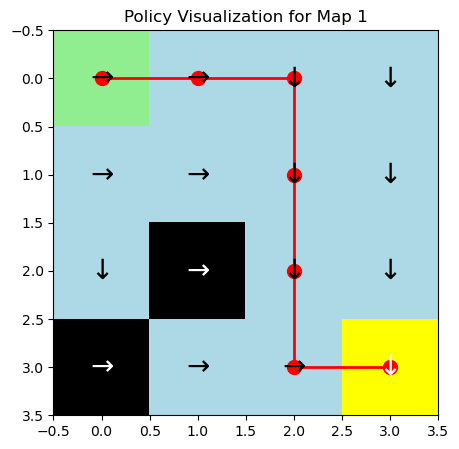

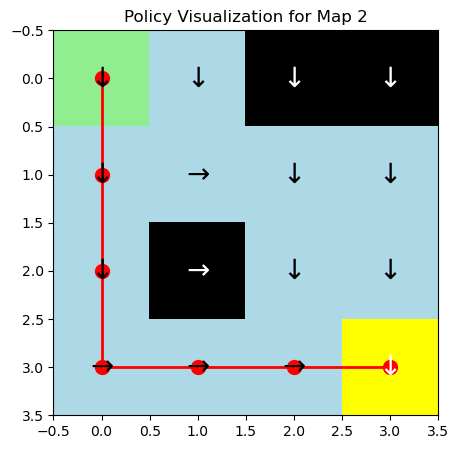

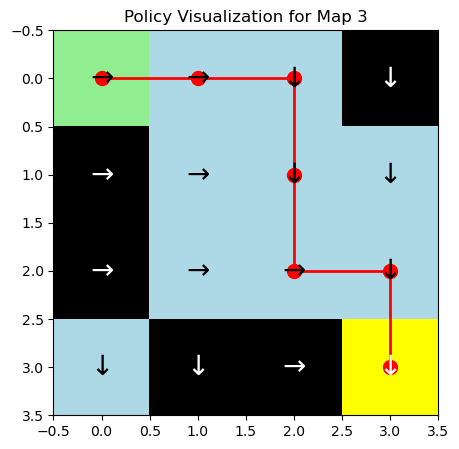

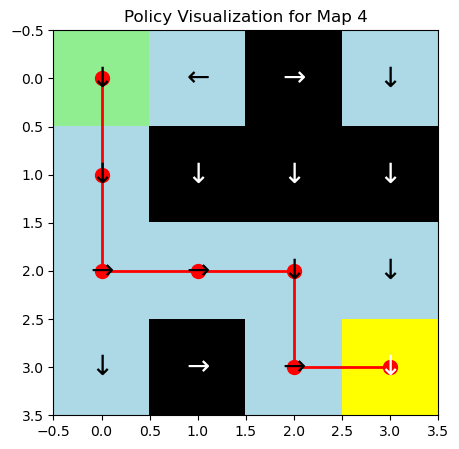

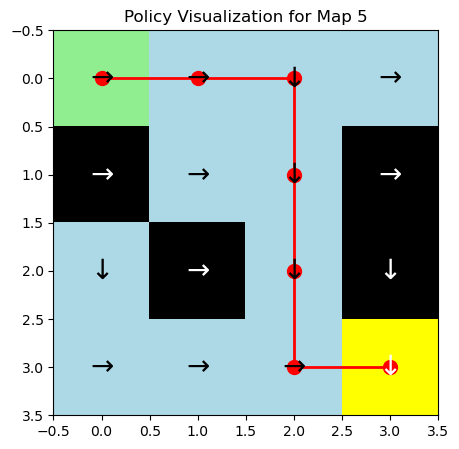

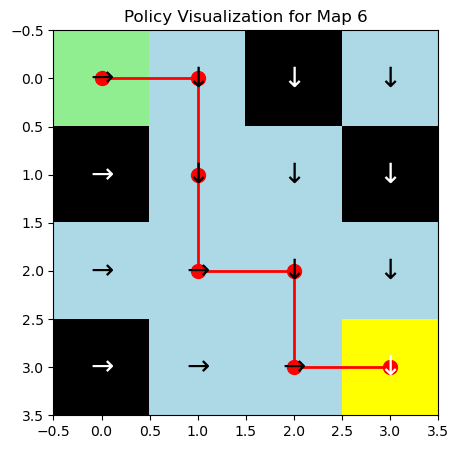

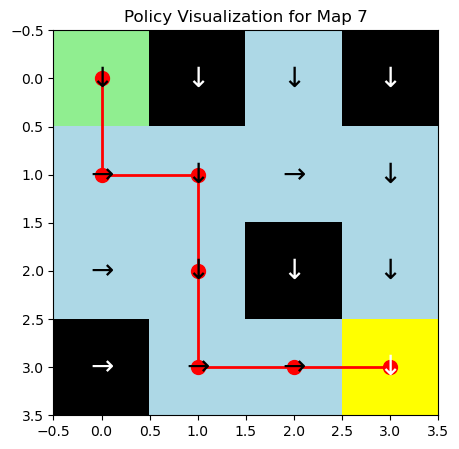

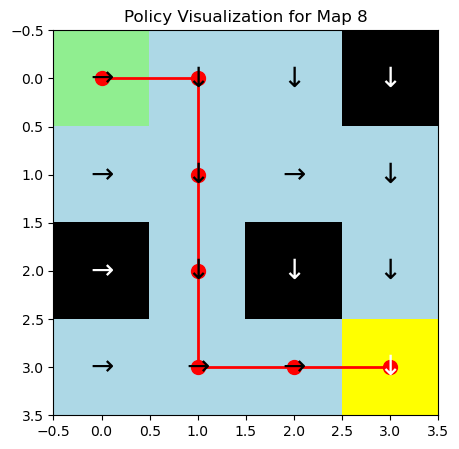

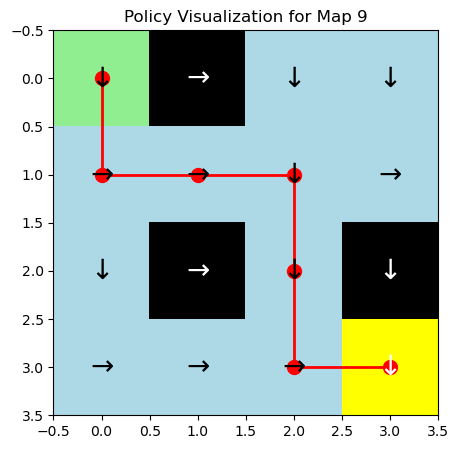

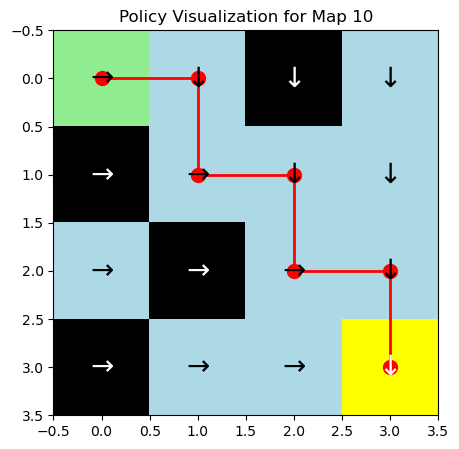

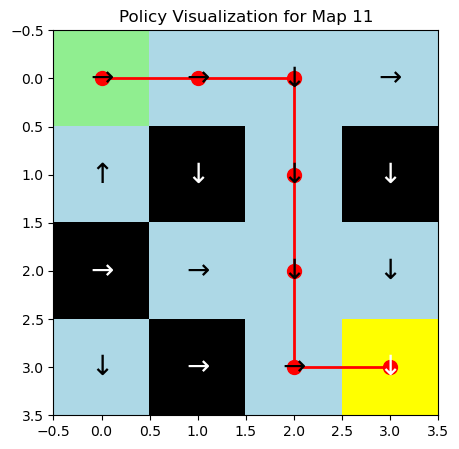

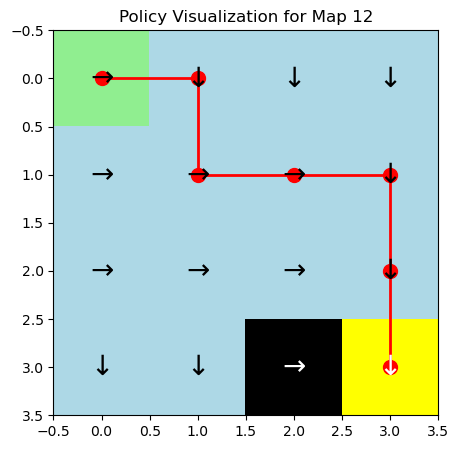

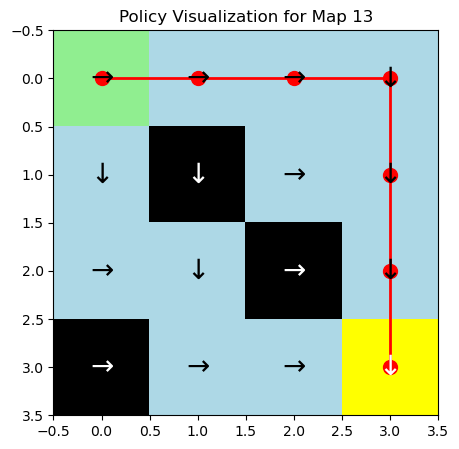

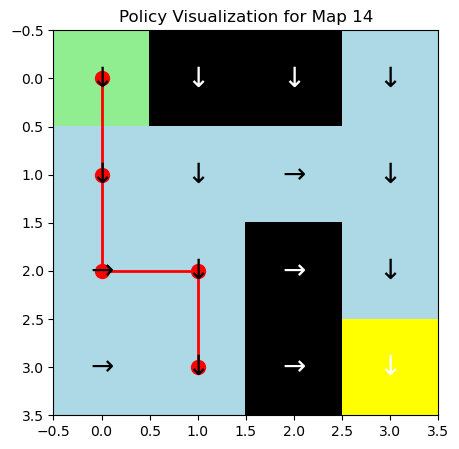

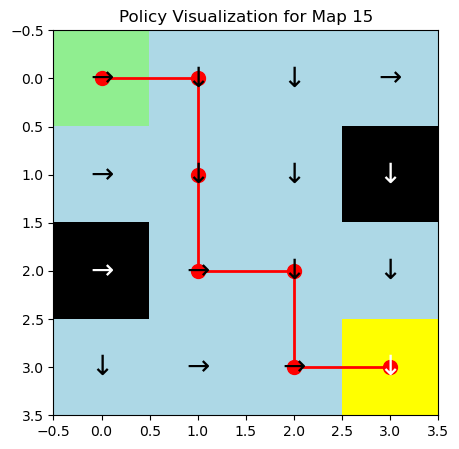

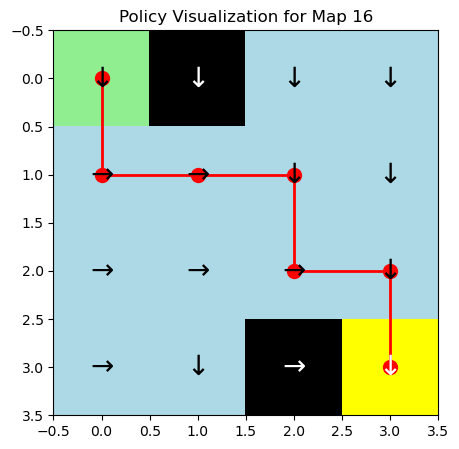

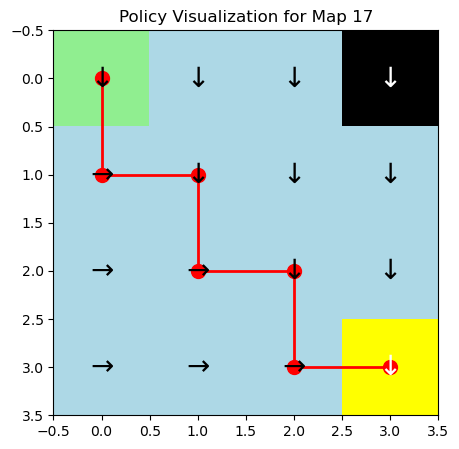

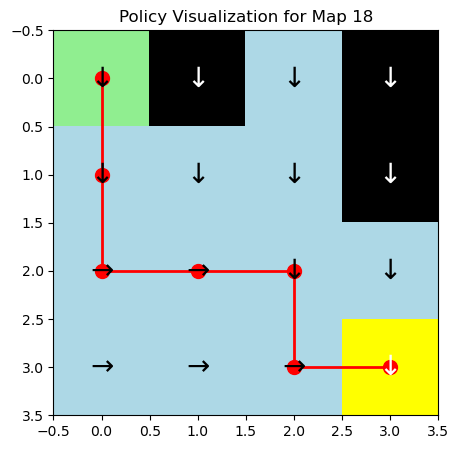

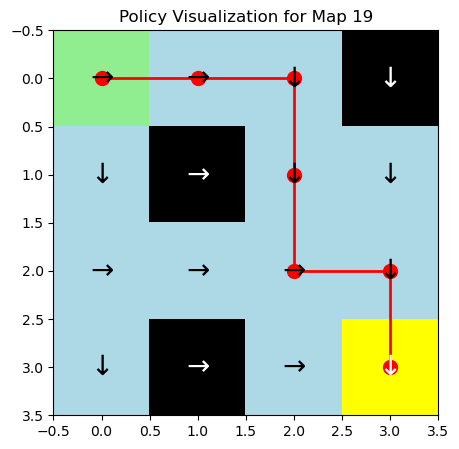

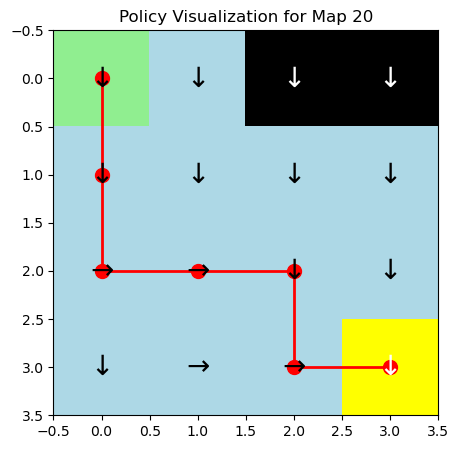

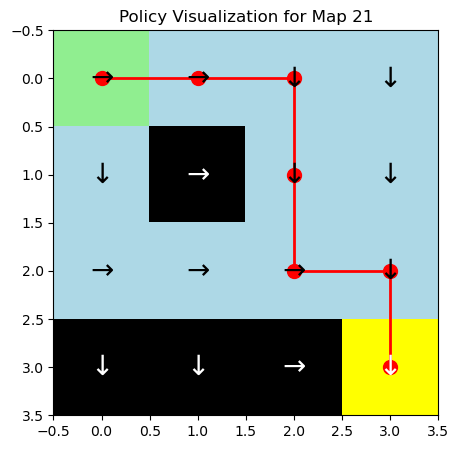

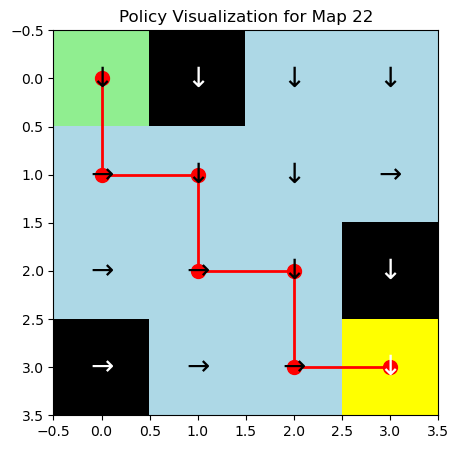

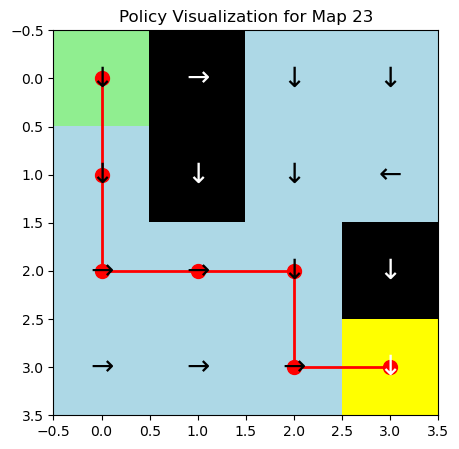

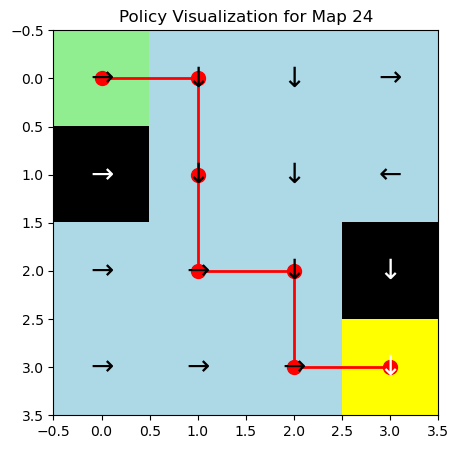

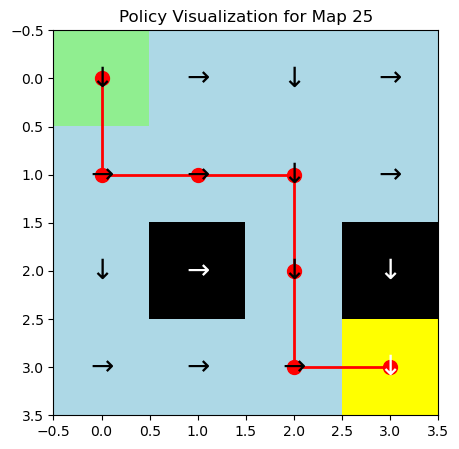

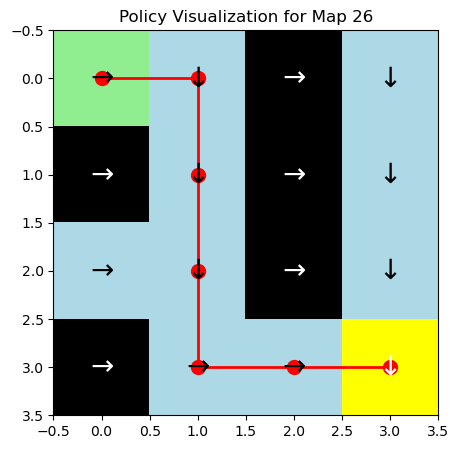

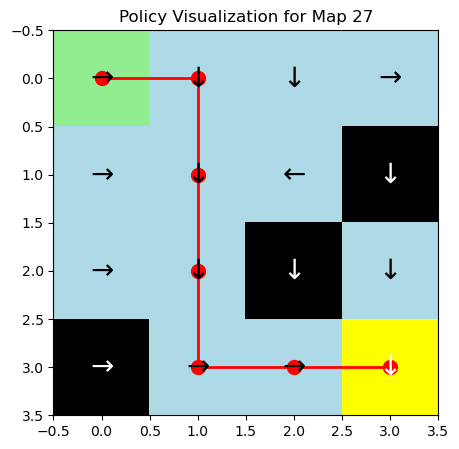

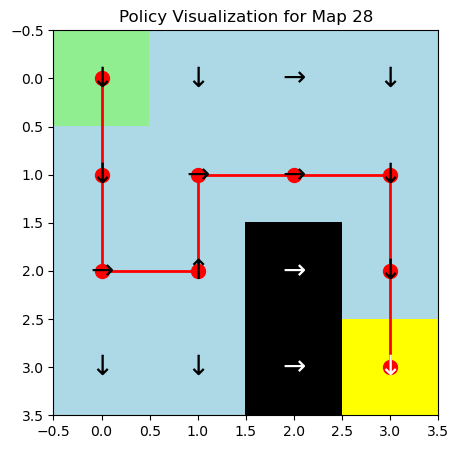

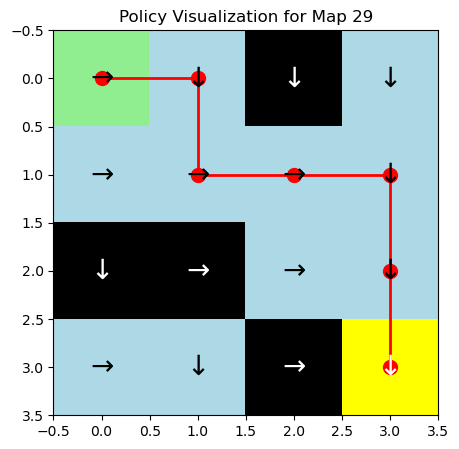

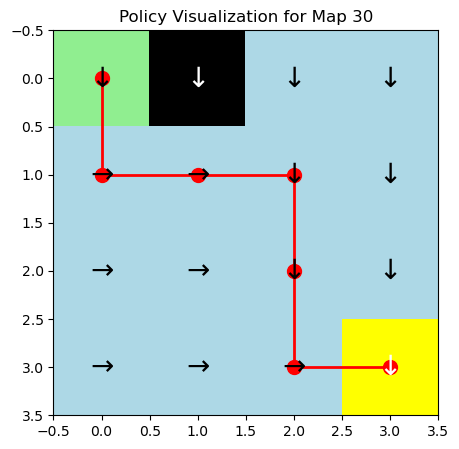

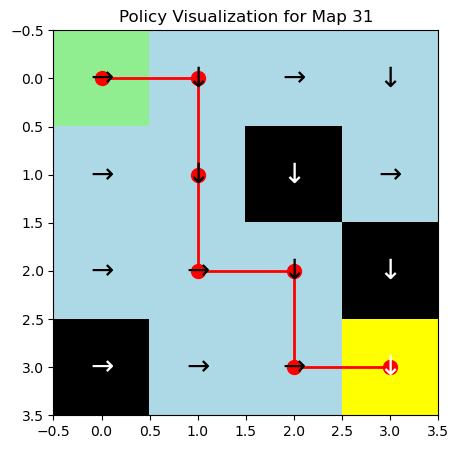

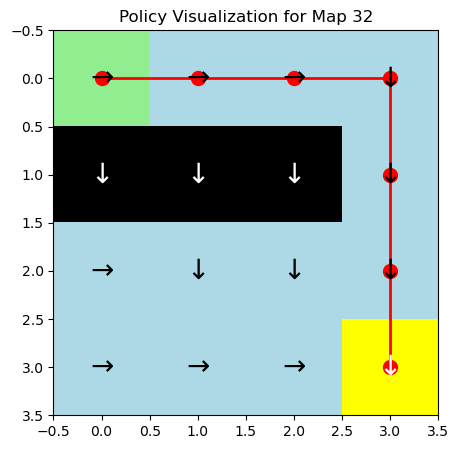

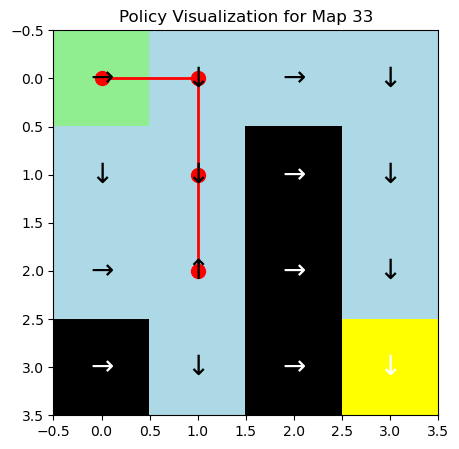

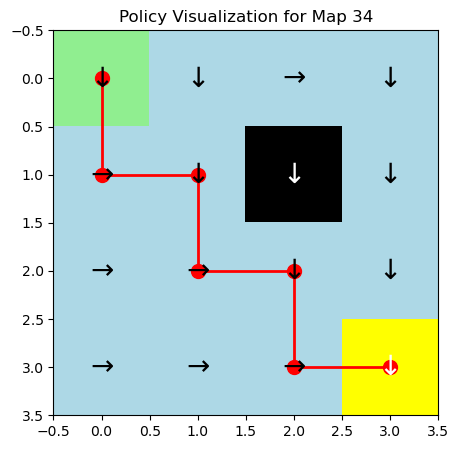

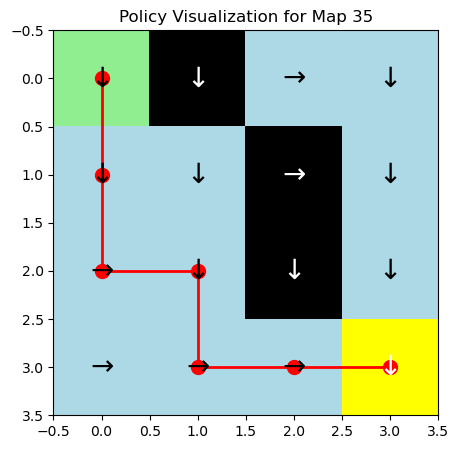

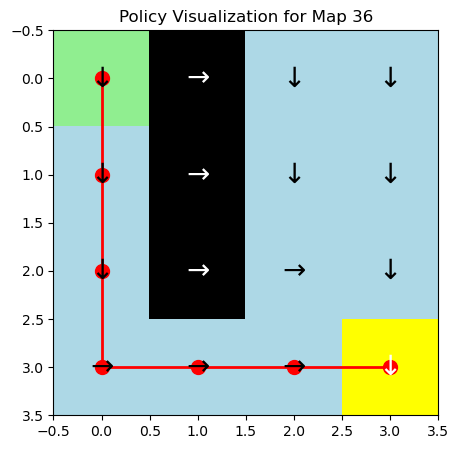

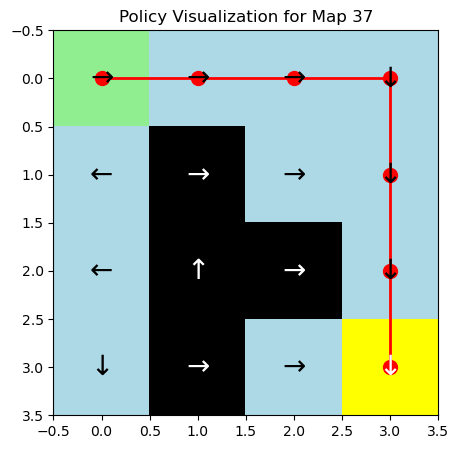

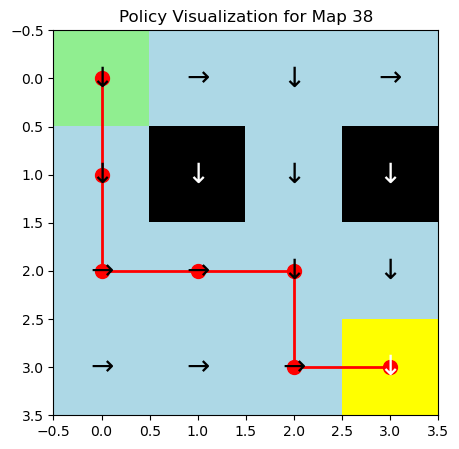

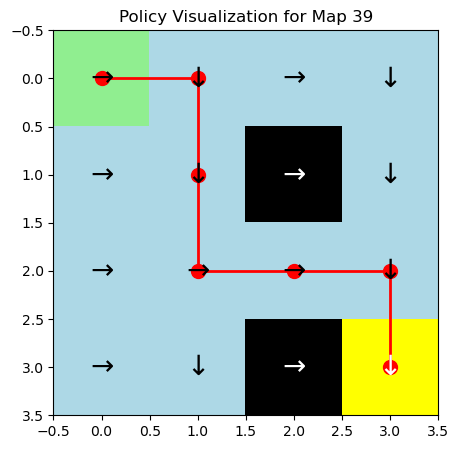

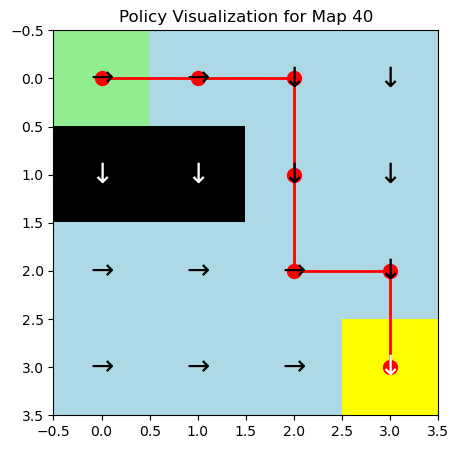

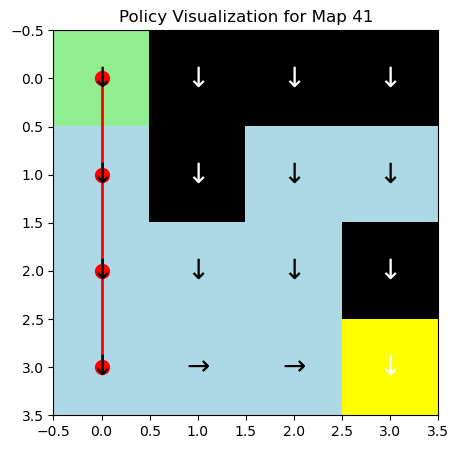

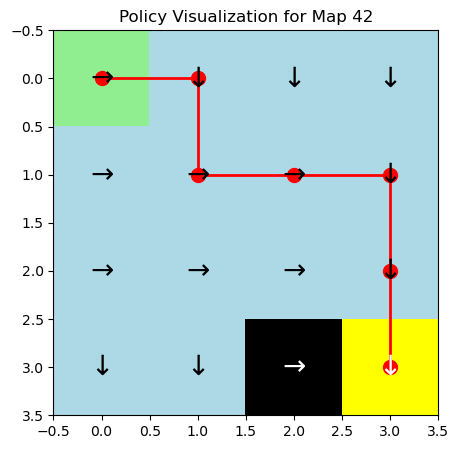

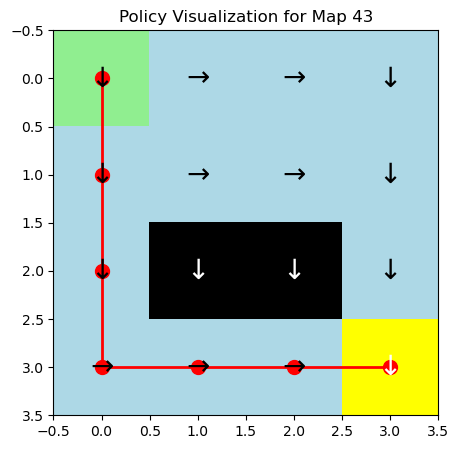

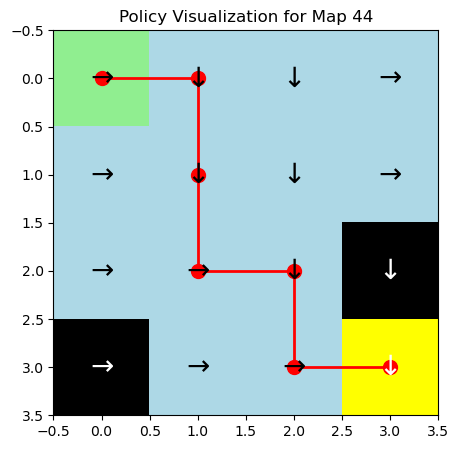

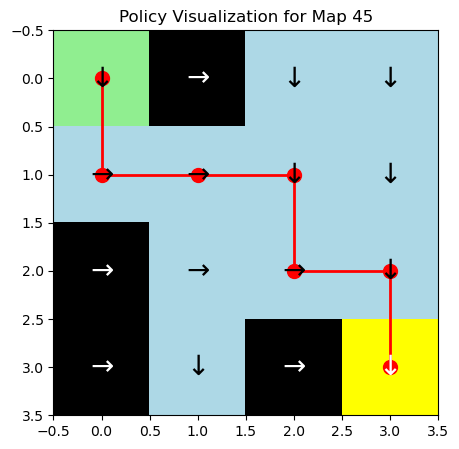

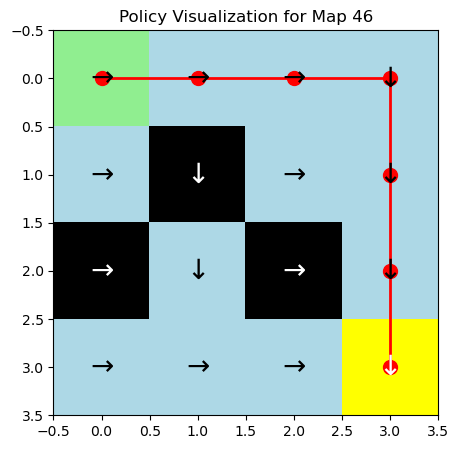

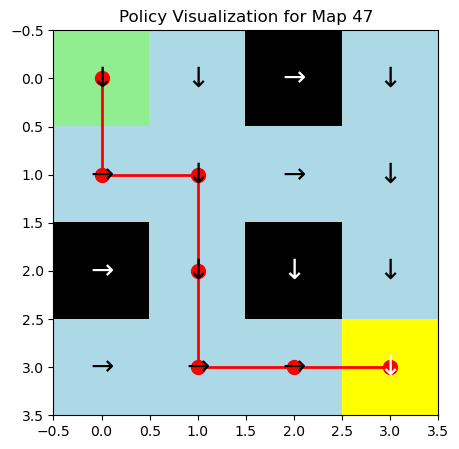

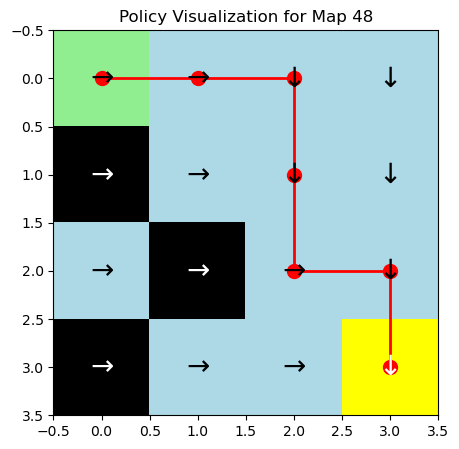

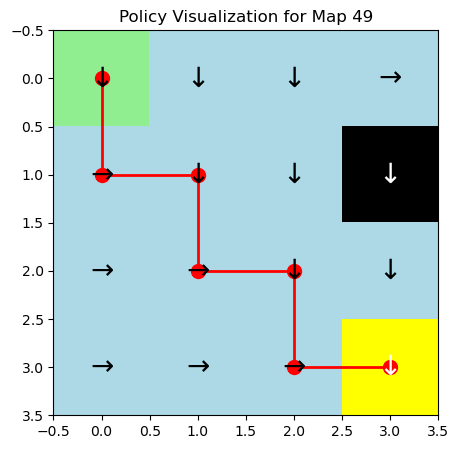

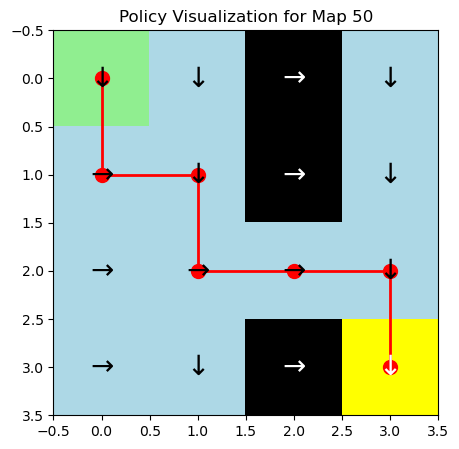

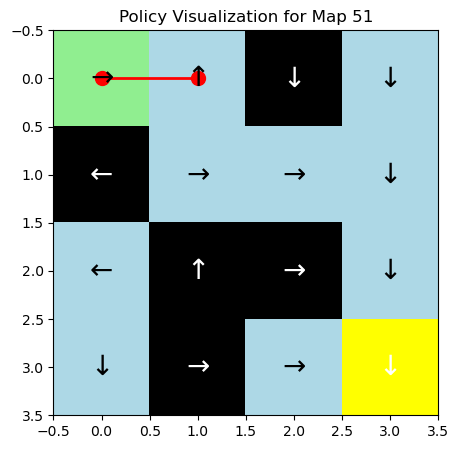

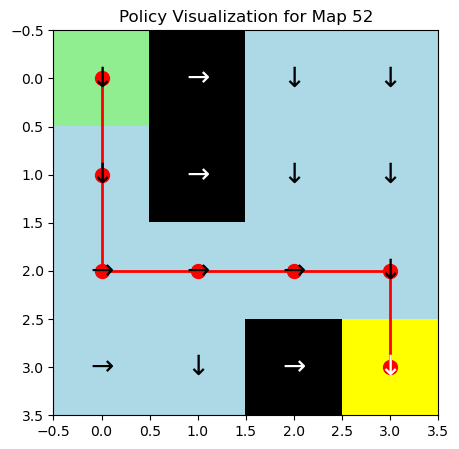

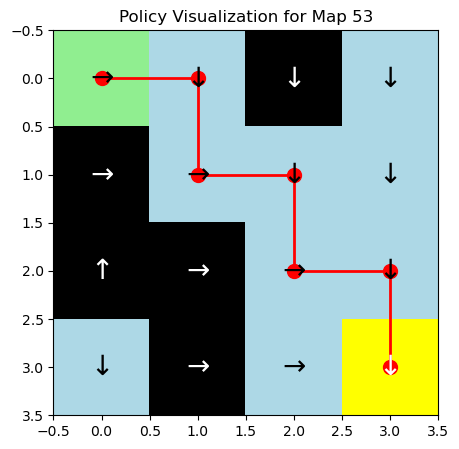

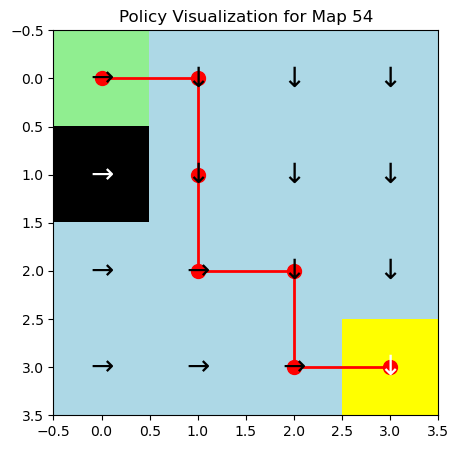

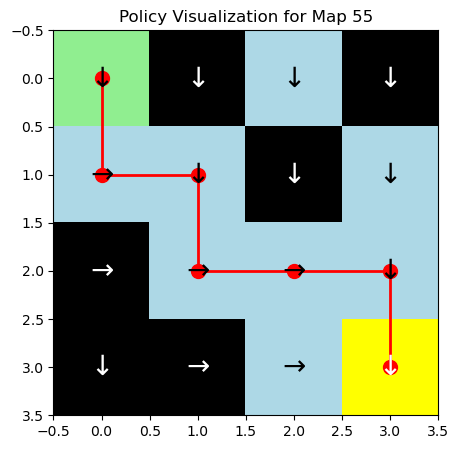

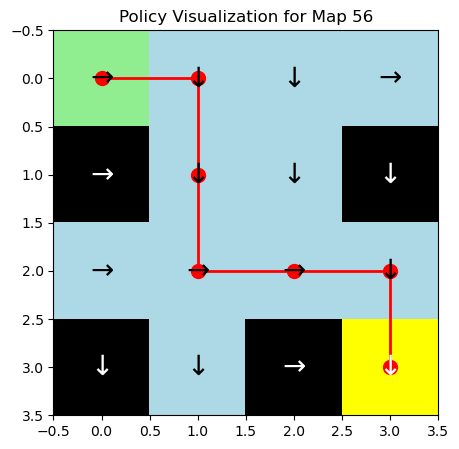

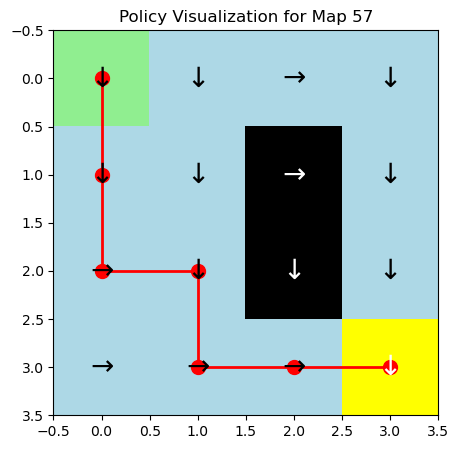

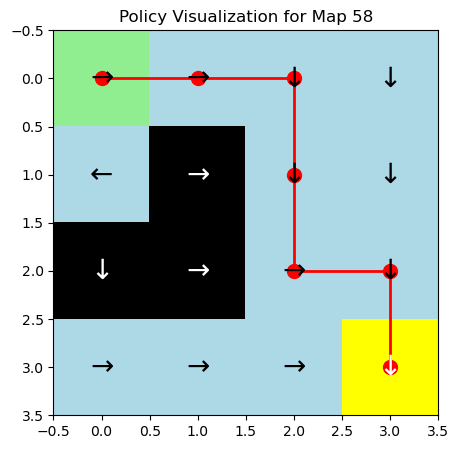

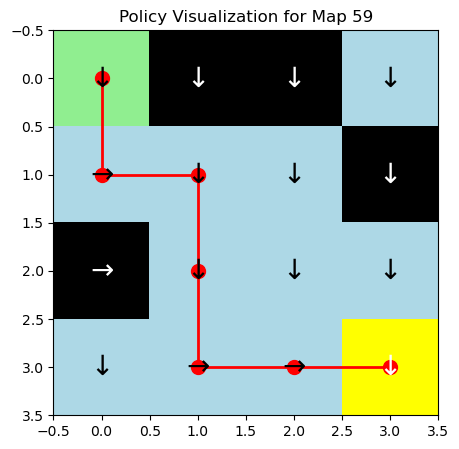

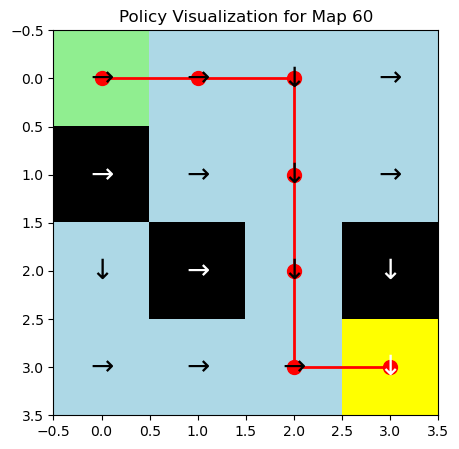

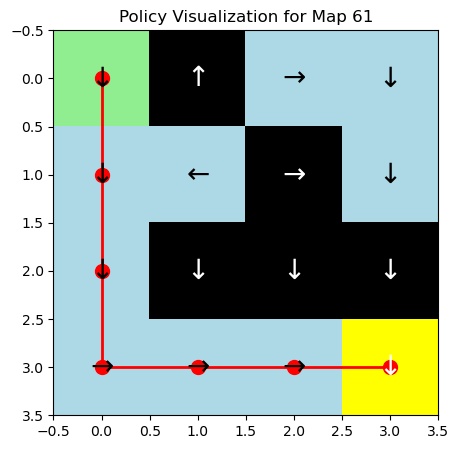

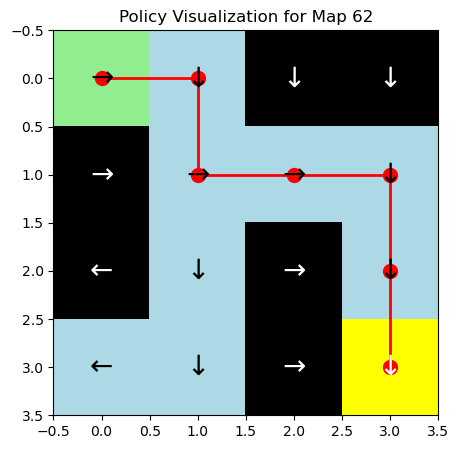

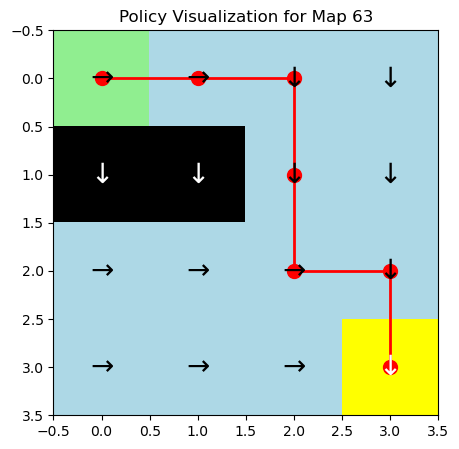

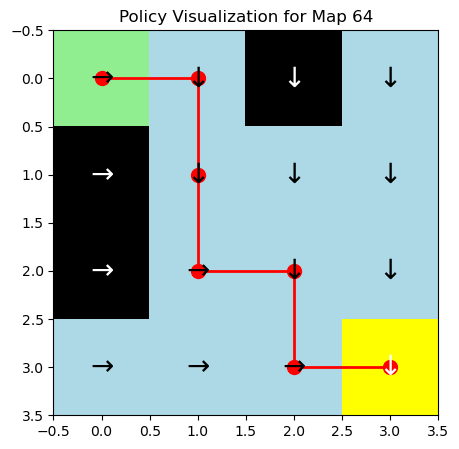

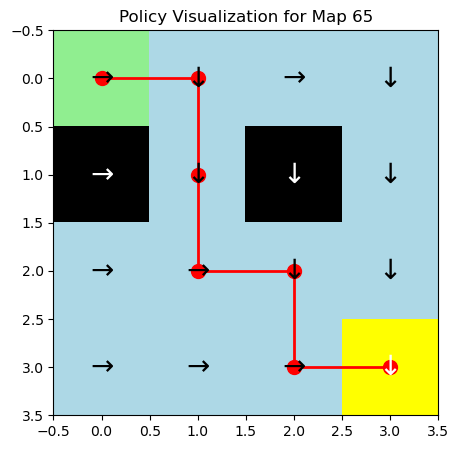

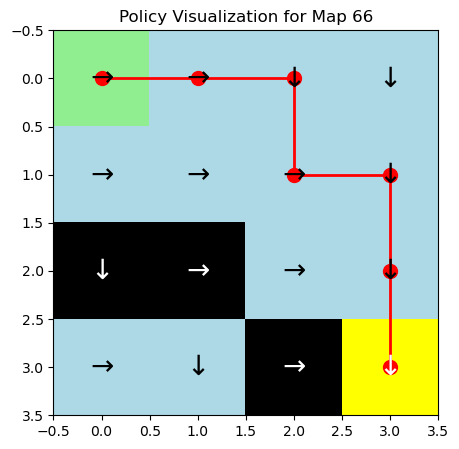

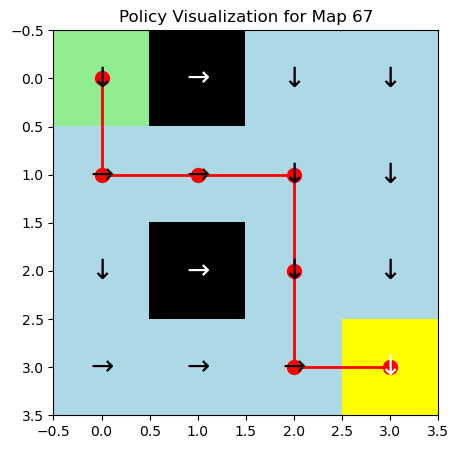

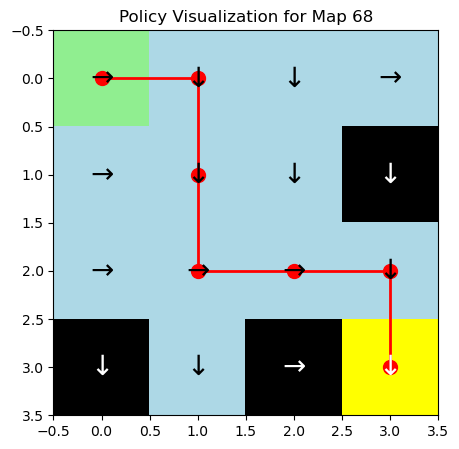

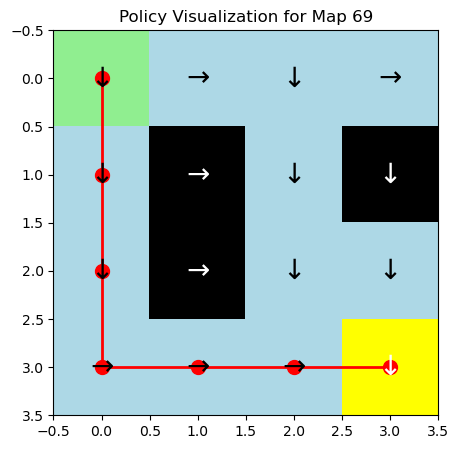

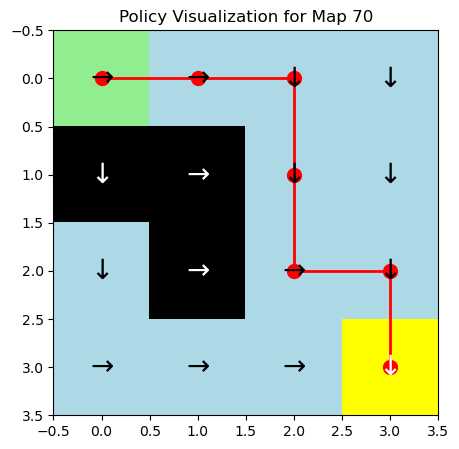

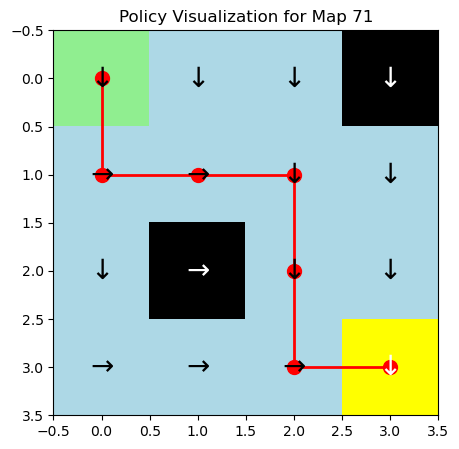

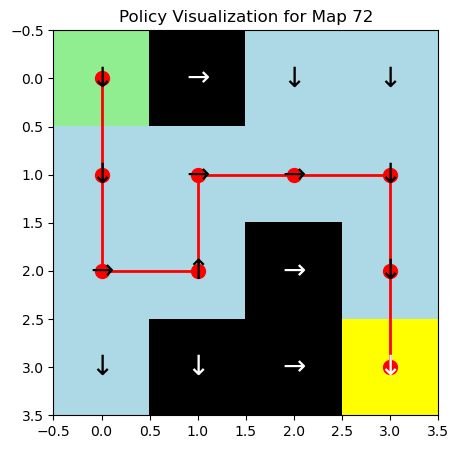

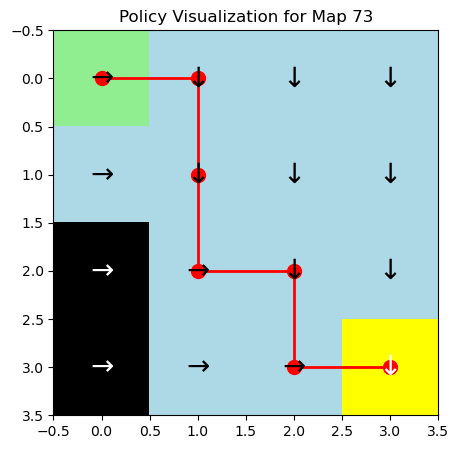

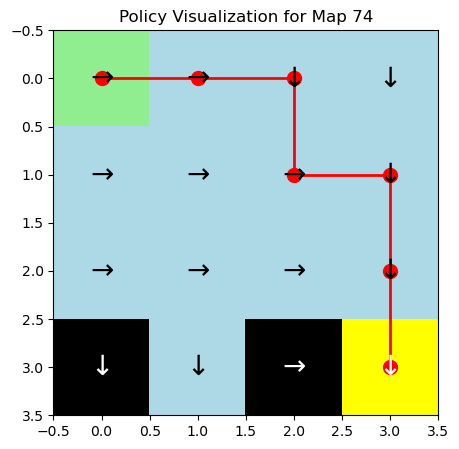

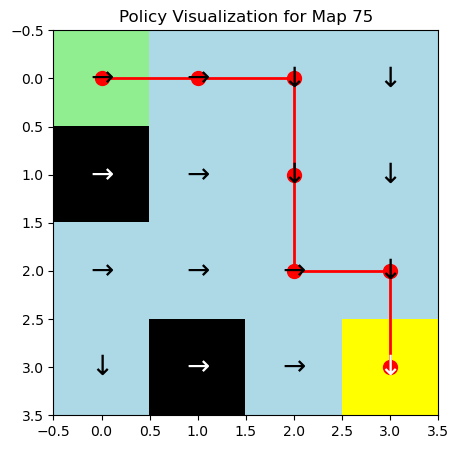

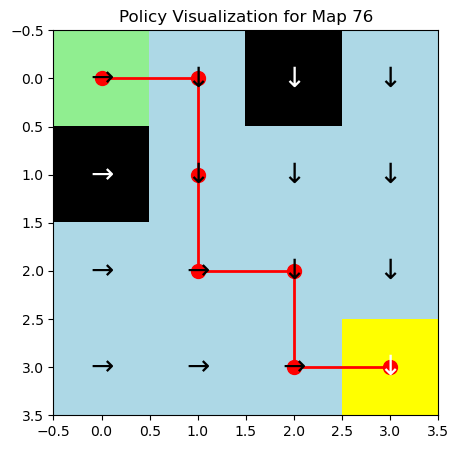

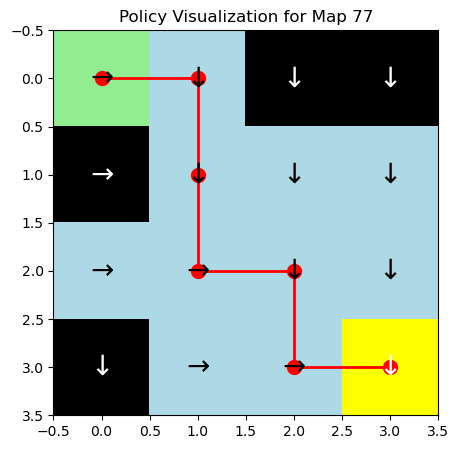

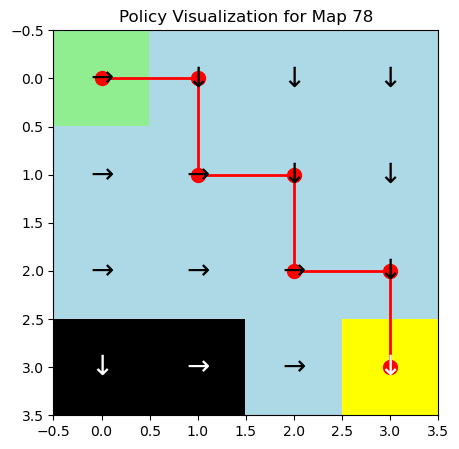

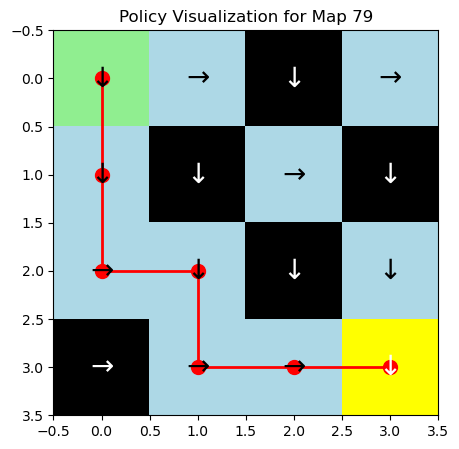

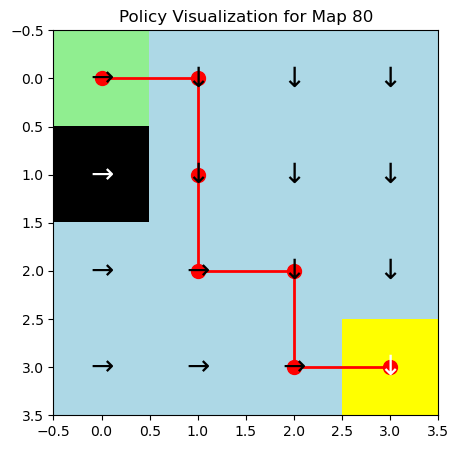

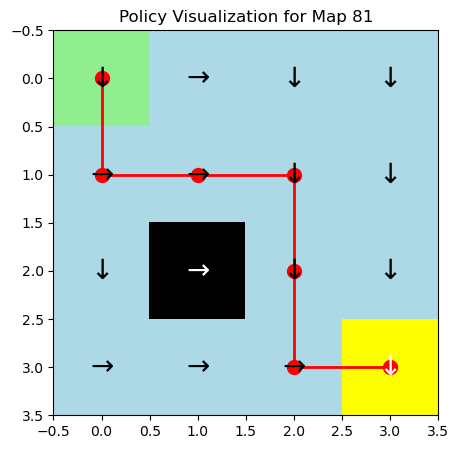

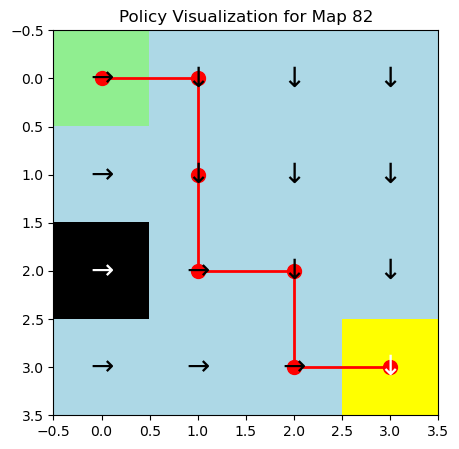

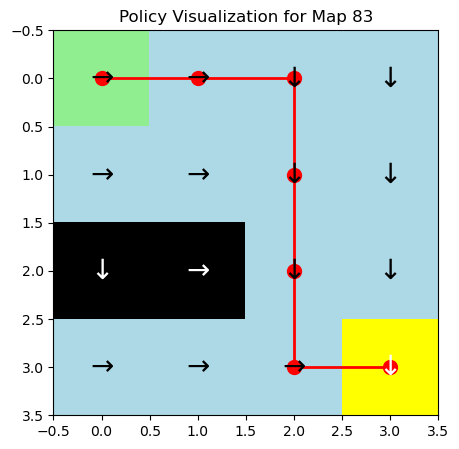

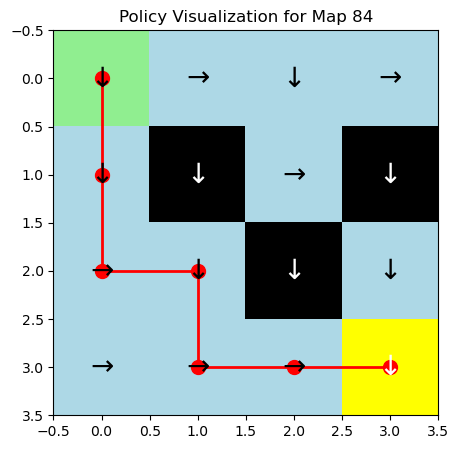

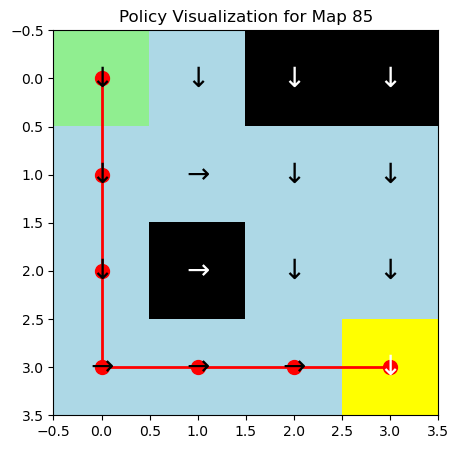

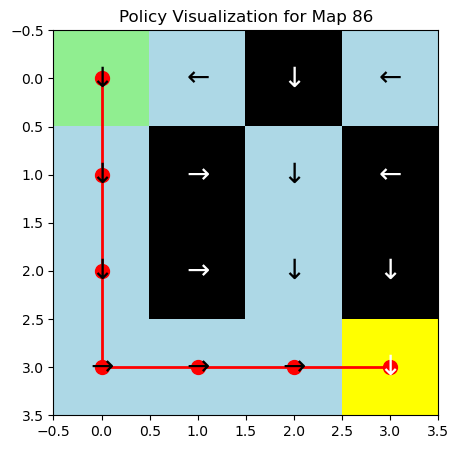

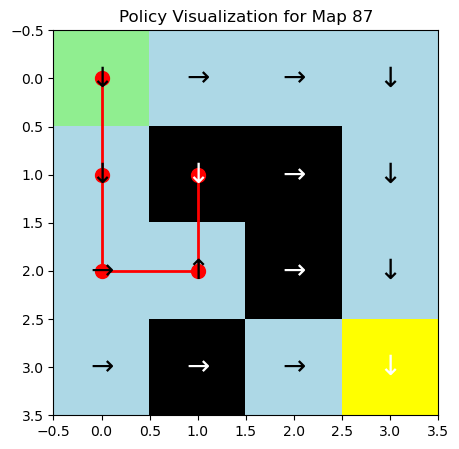

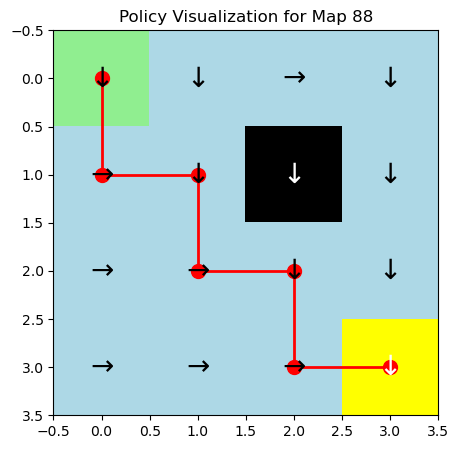

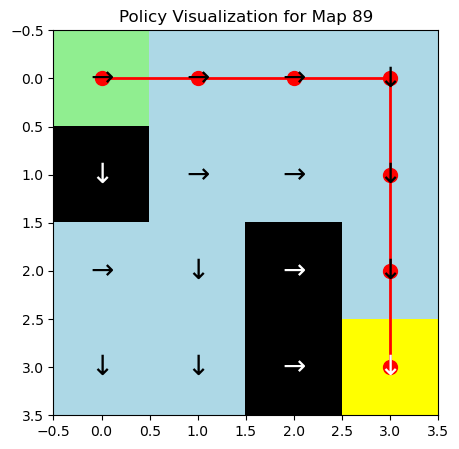

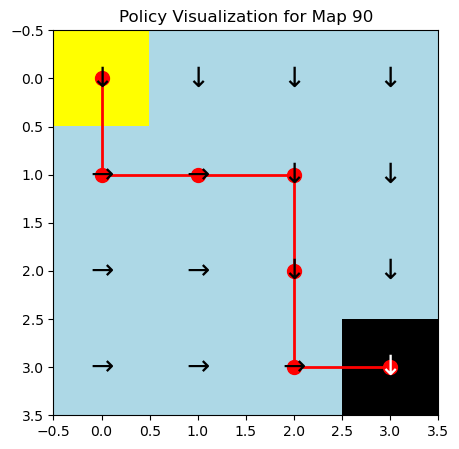

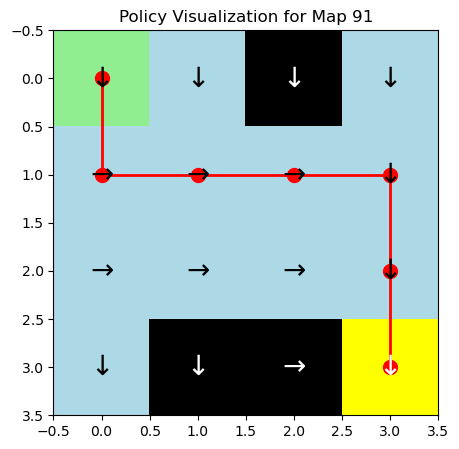

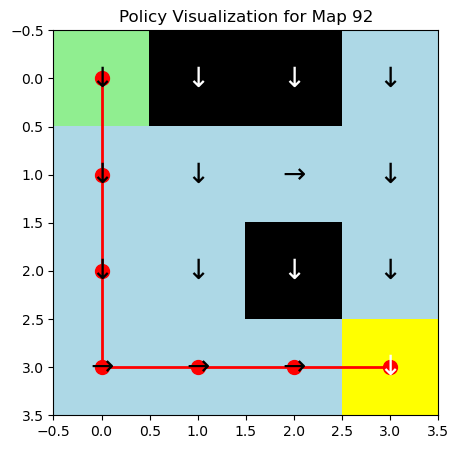

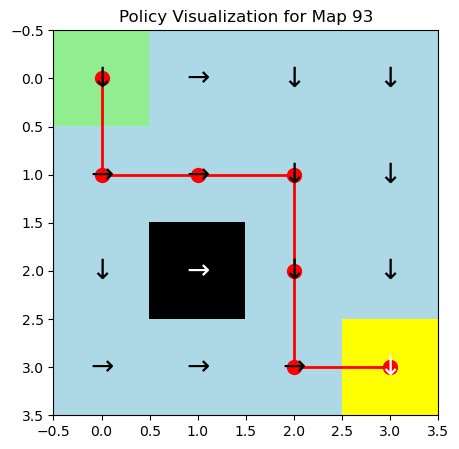

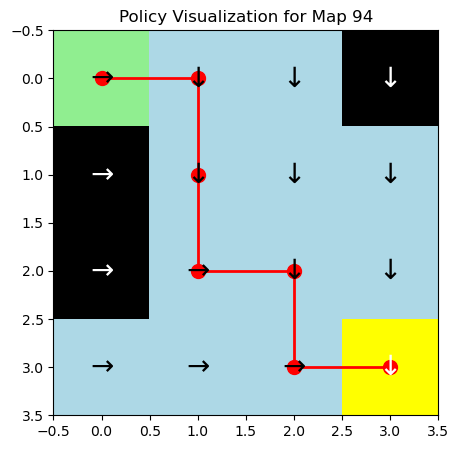

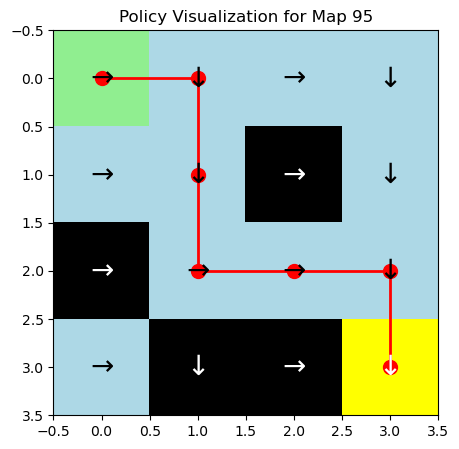

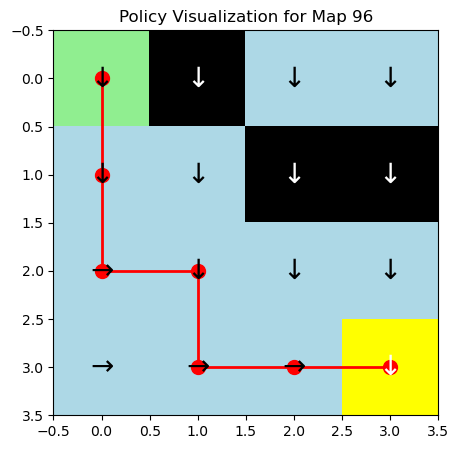

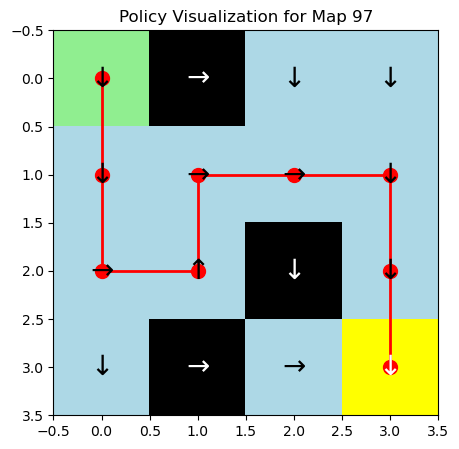

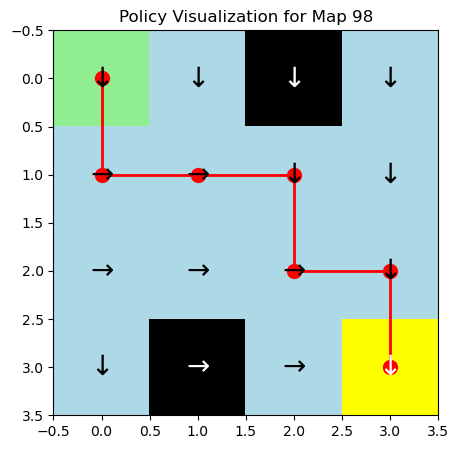

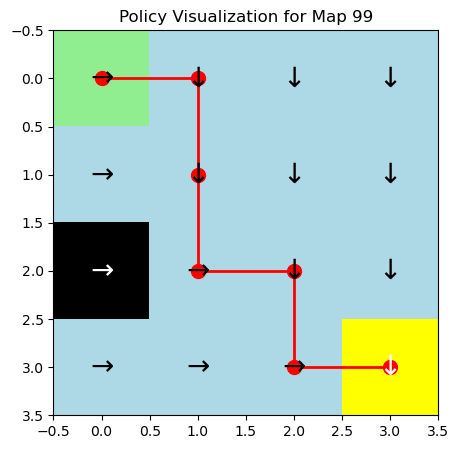

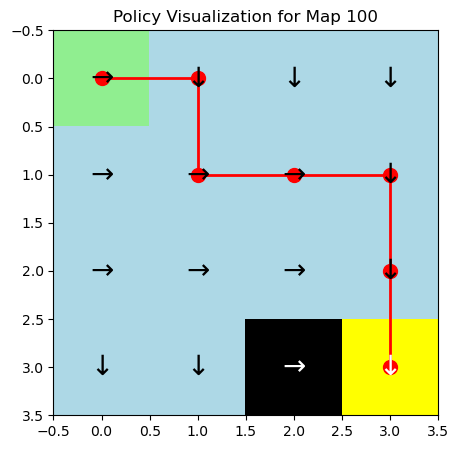

In [392]:
numerical_color_map = {'S': 1, 'F': 0, 'H': 3, 'G': 2}
def visualize_policy_on_random_maps(model, device, n_maps=5, n_states=16, is_slippery=False):
    for map_idx in range(n_maps):
        env = gym.make('FrozenLake-v1', desc=generate_random_map(size=4), is_slippery=is_slippery)
        desc = env.desc.astype(str)

        numerical_grid_colors = np.vectorize(numerical_color_map.get)(desc)

        state_tensors = [preprocess_state(state, env.desc).to(device) for state in range(n_states)]
        batch_states = torch.stack(state_tensors)
        policy_batch = torch.argmax(model(batch_states), dim=1).cpu().numpy()

        action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
        policy_symbols = np.vectorize(action_symbols.get)(policy_batch)
        policy_grid = policy_symbols.reshape(env.desc.shape)

        plt.figure(figsize=(5, 5))
        cmap = ListedColormap(['lightblue', 'lightgreen', 'yellow', 'black'])
        plt.imshow(numerical_grid_colors, cmap=cmap, interpolation='nearest')

        # New: Trace the path
        current_position = np.where(desc == 'S')
        i, j = current_position[0][0], current_position[1][0]  # Extracting the start position
        path_x = [j]
        path_y = [i]

        while True:
            action = policy_grid[i, j]
            if action == '←': j -= 1 
            elif action == '→': j += 1
            elif action == '↑': i -= 1
            elif action == '↓': i += 1
            i = min(max(i, 0), desc.shape[0] - 1)  # Ensuring the agent doesn't go out of bounds
            j = min(max(j, 0), desc.shape[1] - 1)
            if (i, j) in zip(path_y, path_x):
                break
            path_x.append(j)
            path_y.append(i)
            if desc[i, j] in ['H', 'G']:
                break

        # Draw the path
        plt.plot(path_x, path_y, 'ro-', linewidth=2, markersize=10)

        for i in range(desc.shape[0]):
            for j in range(desc.shape[1]):
                arrow = policy_grid[i, j]
                arrow_color = 'white' if desc[i, j] in ['H', 'G'] else 'black'
                plt.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=20, color=arrow_color)

        plt.title(f'Policy Visualization for Map {map_idx+1}')
        plt.show()


visualize_policy_on_random_maps(model, device, n_maps=100, is_slippery=is_slippery)